In [6]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [4]:
from online_analysis import util_fcns, sim_utils

<IPython.core.display.Javascript object>


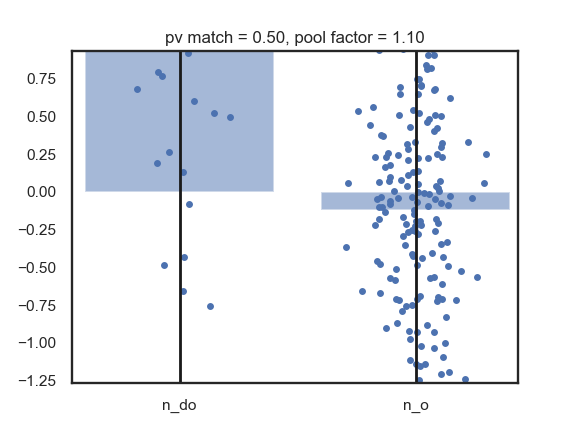

<IPython.core.display.Javascript object>


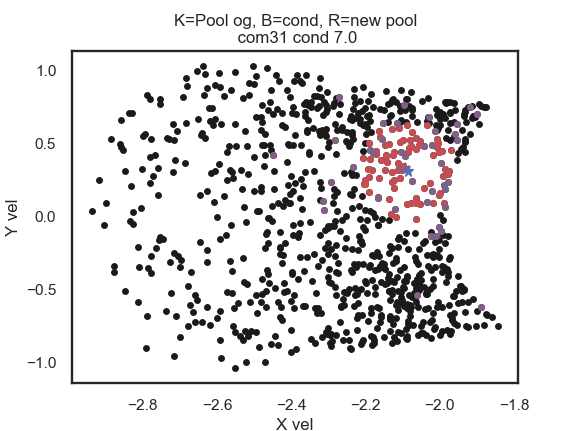

<IPython.core.display.Javascript object>


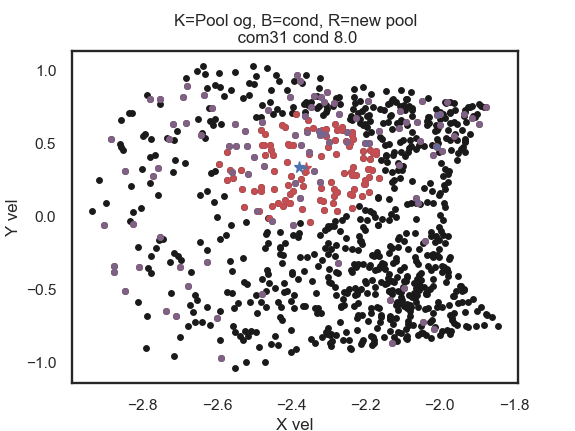

<IPython.core.display.Javascript object>


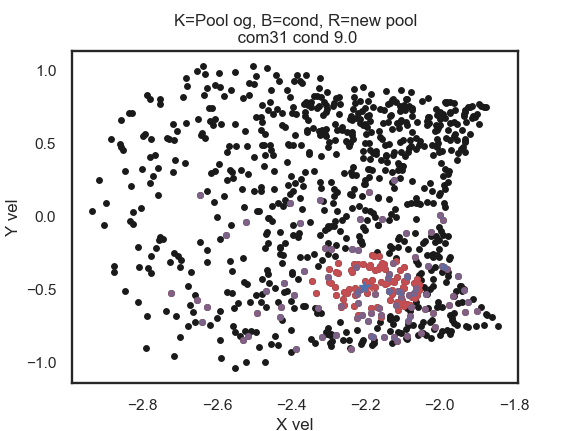

<IPython.core.display.Javascript object>


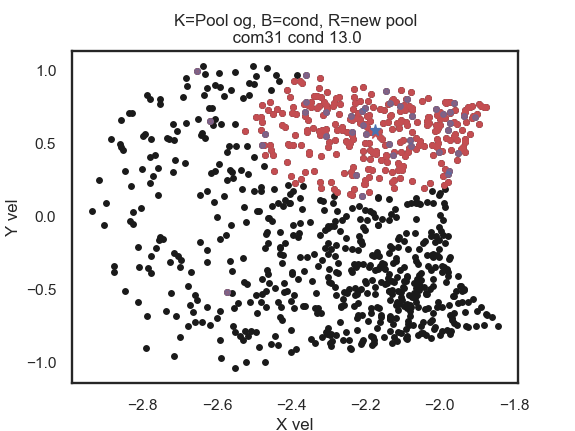

<IPython.core.display.Javascript object>


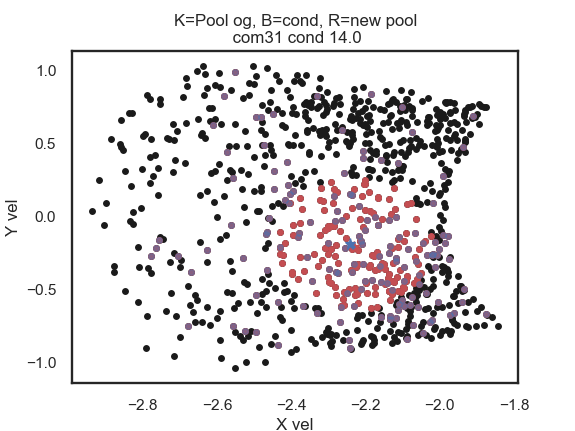

<IPython.core.display.Javascript object>


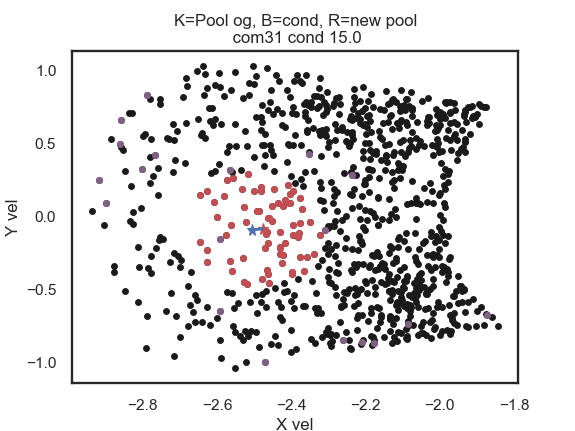

<IPython.core.display.Javascript object>


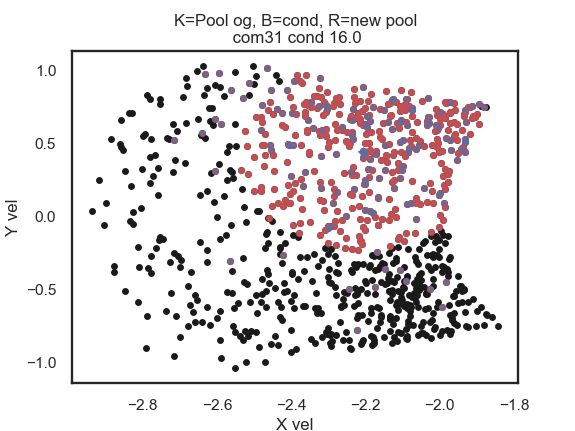

<IPython.core.display.Javascript object>


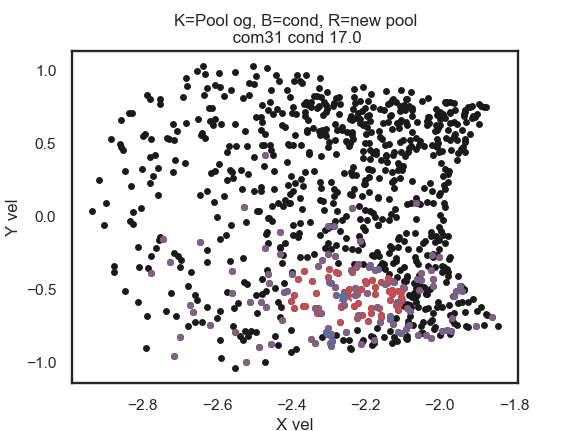

<IPython.core.display.Javascript object>


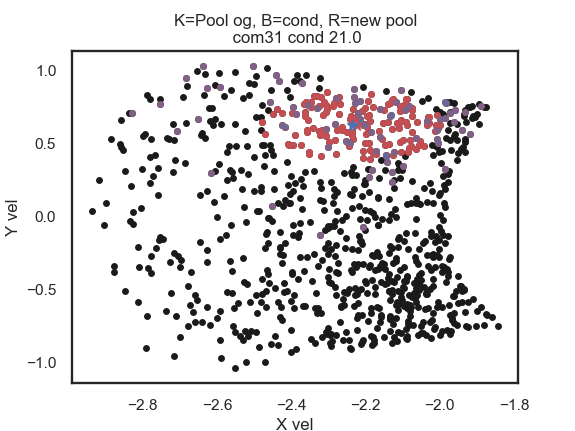

<IPython.core.display.Javascript object>


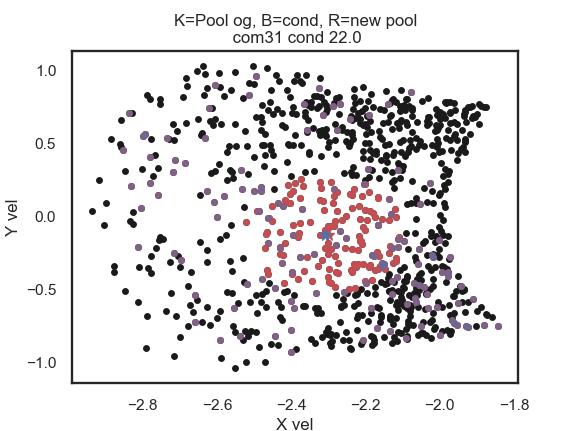

<IPython.core.display.Javascript object>


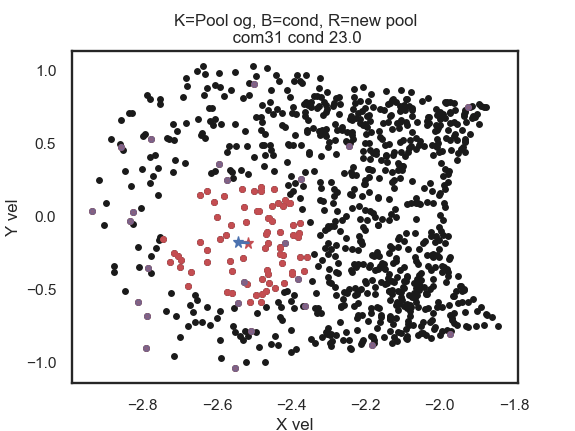

Model n_do: # commands: 296
GT20: (13, 4.0)
GT20: (27, 17.0)
GT20: (18, 19.0)
GT20: (29, 22.0)
GT20: (30, 13.0)
GT20: (31, 21.0)
GT20: (6, 7.0)
GT20: (5, 5.0)
GT20: (30, 23.0)
GT20: (31, 22.0)
GT20: (19, 3.0)
GT20: (0, 4.0)
GT20: (21, 12.0)
GT20: (1, 1.0)
GT20: (24, 18.0)
GT20: (3, 2.0)
GT20: (31, 7.0)
GT20: (17, 18.0)
GT20: (19, 10.0)
GT20: (14, 16.0)
GT20: (0, 1.0)
GT20: (31, 13.0)
GT20: (6, 13.0)
GT20: (17, 8.0)
GT20: (24, 16.0)
GT20: (22, 23.0)
GT20: (28, 22.0)
GT20: (17, 19.0)
GT20: (28, 10.0)
GT20: (10, 3.0)
GT20: (14, 5.0)
GT20: (15, 0.0)
GT20: (2, 2.0)
GT20: (5, 4.0)
GT20: (14, 6.0)
GT20: (9, 2.0)
GT20: (8, 22.0)
GT20: (7, 17.0)
GT20: (28, 18.0)
GT20: (31, 15.0)
GT20: (14, 20.0)
GT20: (9, 18.0)
GT20: (19, 20.0)
GT20: (14, 8.0)
GT20: (27, 10.0)
GT20: (21, 11.0)
GT20: (12, 3.0)
GT20: (0, 22.0)
GT20: (24, 15.0)
GT20: (2, 3.0)
GT20: (7, 0.0)
GT20: (28, 11.0)
GT20: (16, 8.0)
GT20: (14, 7.0)
GT20: (20, 11.0)
GT20: (15, 6.0)
GT20: (29, 23.0)
GT20: (31, 14.0)
GT20: (30, 16.0)
GT20: (27

<IPython.core.display.Javascript object>


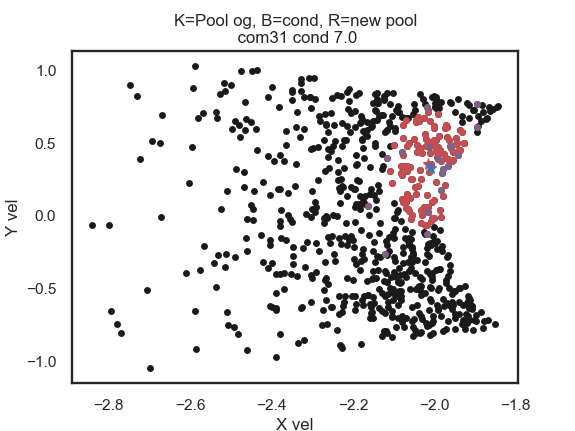

<IPython.core.display.Javascript object>


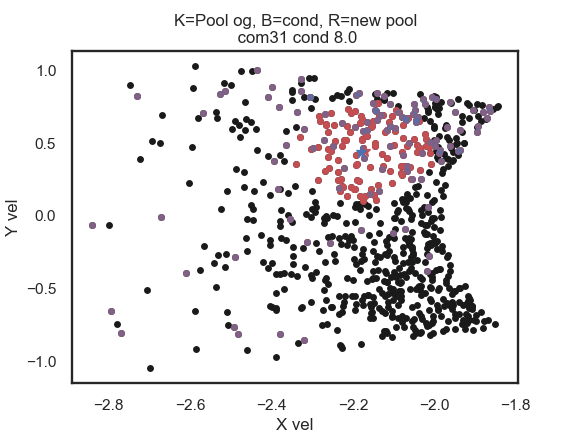

<IPython.core.display.Javascript object>


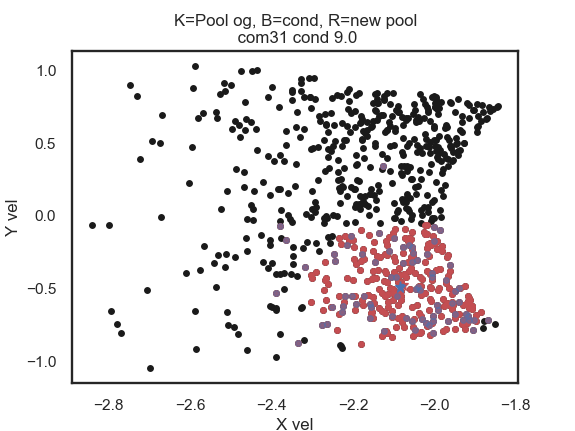

<IPython.core.display.Javascript object>


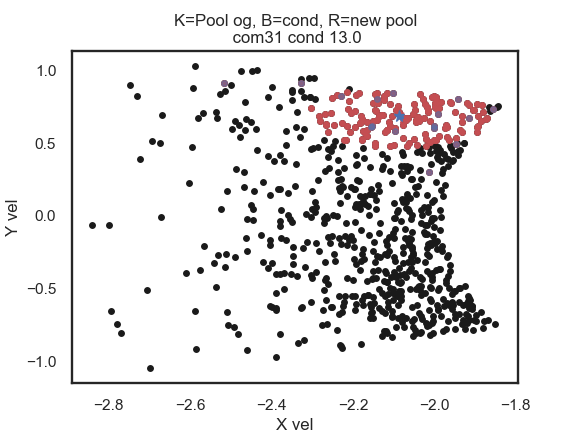

<IPython.core.display.Javascript object>


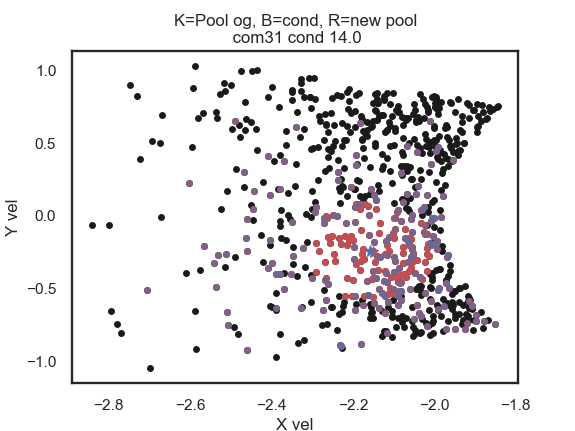

<IPython.core.display.Javascript object>


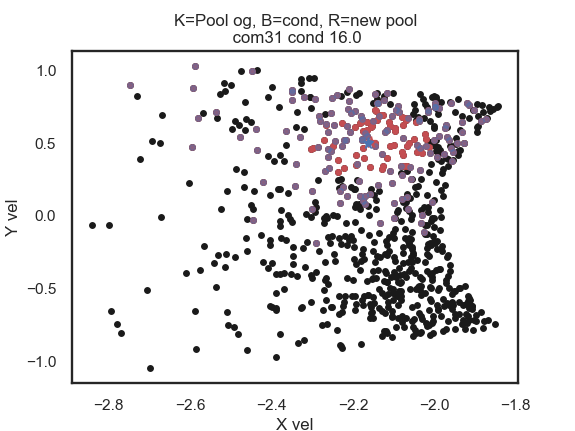

<IPython.core.display.Javascript object>


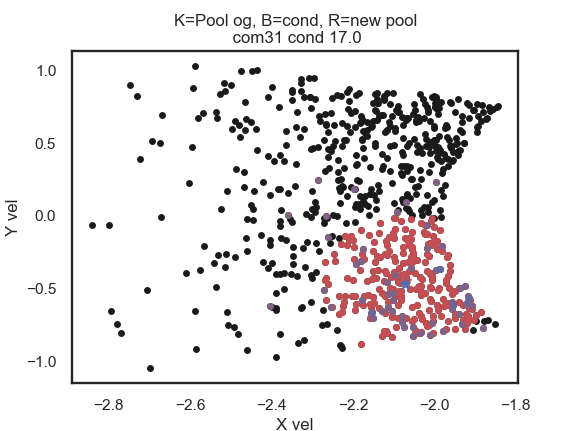

<IPython.core.display.Javascript object>


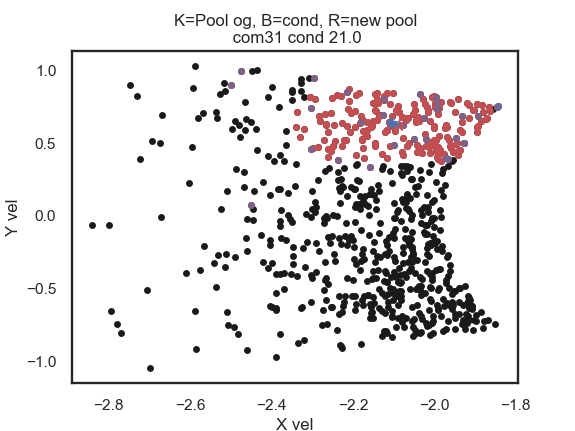

<IPython.core.display.Javascript object>


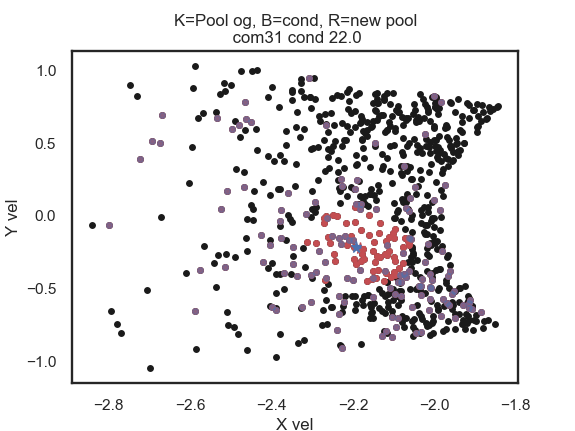

Model n_o: # commands: 224
mn -2.100, max 1.857


In [81]:
for pv in [.5]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        ### get out data
        for i_m, model in enumerate(['n_do', 'n_o']): 
            activity, com, cond, pot, null, _ = sim_utils.return_lqr_data(model = model, dyn='full')
            
            cc_dist, shuff_cc_dist = sim_utils.get_cond_com_pls_matched_inds(com, cond, activity, pot, nshuff=50,
                                                                pv=pv, pool_factor=pool_factor, min_commands=15)
            
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            
            ax = sim_utils.plot2(cc_dist, shuff_cc_dist, i_m, ax)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['n_do', 'n_o'])
        ax.set_title('pv match = %.2f, pool factor = %.2f'%(pv, pool_factor))

<IPython.core.display.Javascript object>


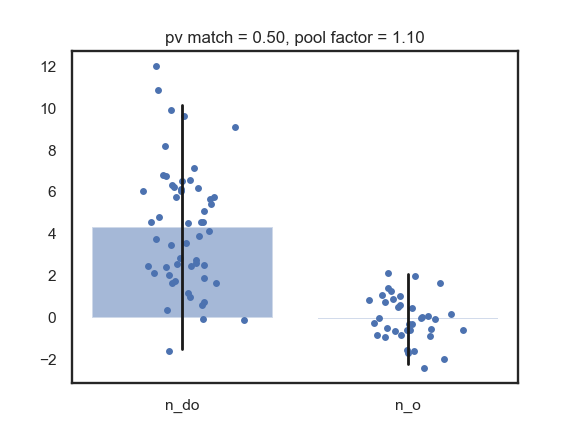

<IPython.core.display.Javascript object>


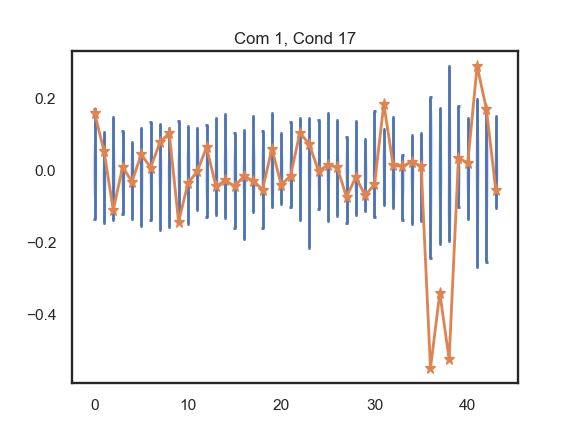

<IPython.core.display.Javascript object>


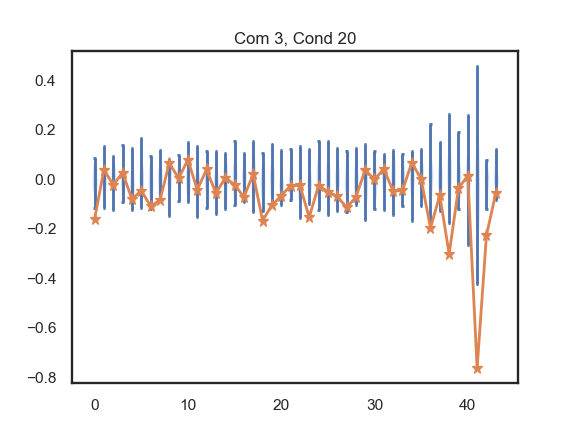

<IPython.core.display.Javascript object>


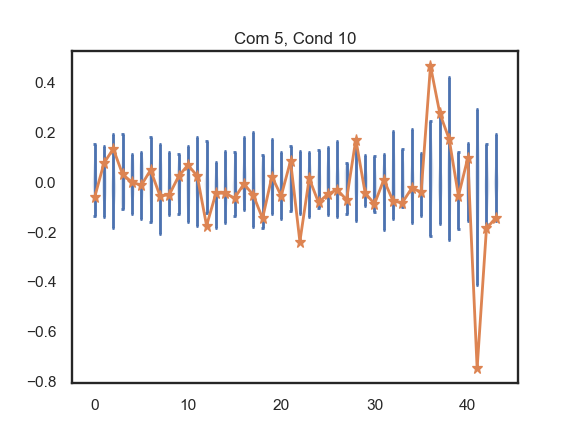

<IPython.core.display.Javascript object>


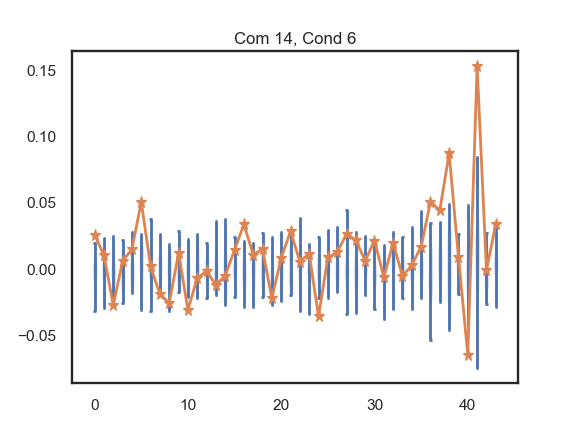

<IPython.core.display.Javascript object>


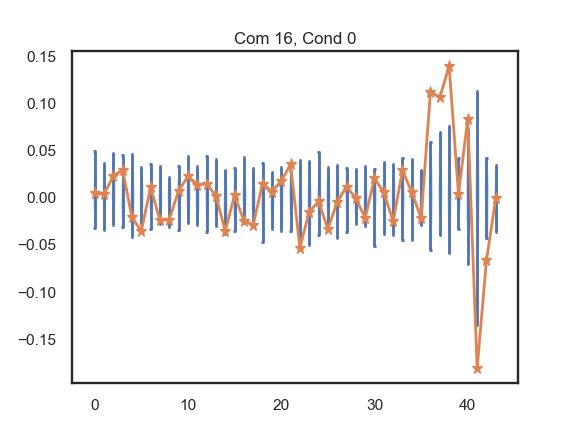

<IPython.core.display.Javascript object>


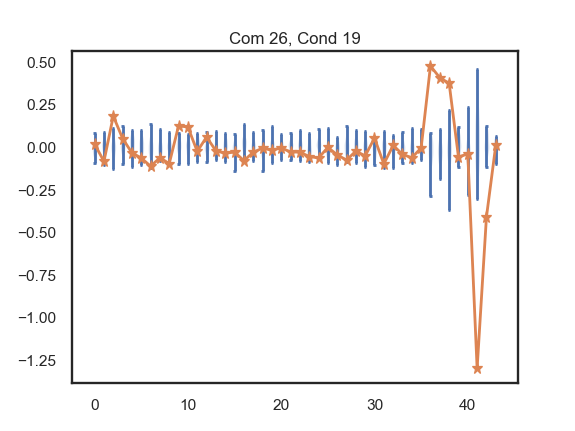

Model n_do: # commands: 54
GT20: (1, 17.0)
GT20: (3, 20.0)
GT20: (14, 6.0)
GT20: (5, 10.0)
GT20: (16, 0.0)
GT20: (26, 19.0)
mn -1.505, max 10.160
Model n_o: # commands: 37
mn -2.217, max 2.088


In [54]:
for pv in [.5]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        ### get out data
        for i_m, model in enumerate(['n_do', 'n_o']): 
            activity, com, cond, pot, null, _ = sim_utils.return_lqr_data(model = model, dyn='full')
            
            cc_dist, shuff_cc_dist = sim_utils.get_cond_com_pls_matched_inds(com, cond, activity, pot, nshuff=50,
                                                                pv=pv, pool_factor=pool_factor, min_commands=15)
            
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            
            ax = sim_utils.plot2(cc_dist, shuff_cc_dist, i_m, ax)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['n_do', 'n_o'])
        ax.set_title('pv match = %.2f, pool factor = %.2f'%(pv, pool_factor))

In [34]:
pdb

Automatic pdb calling has been turned ON


In [4]:
### Plot out resutsl

In [16]:
####### distributions of true vs shuffle; 

<IPython.core.display.Javascript object>


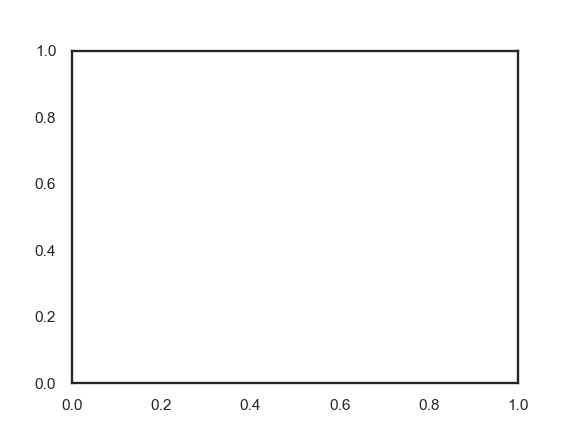

Model n_do: # commands: 160


<IPython.core.display.Javascript object>


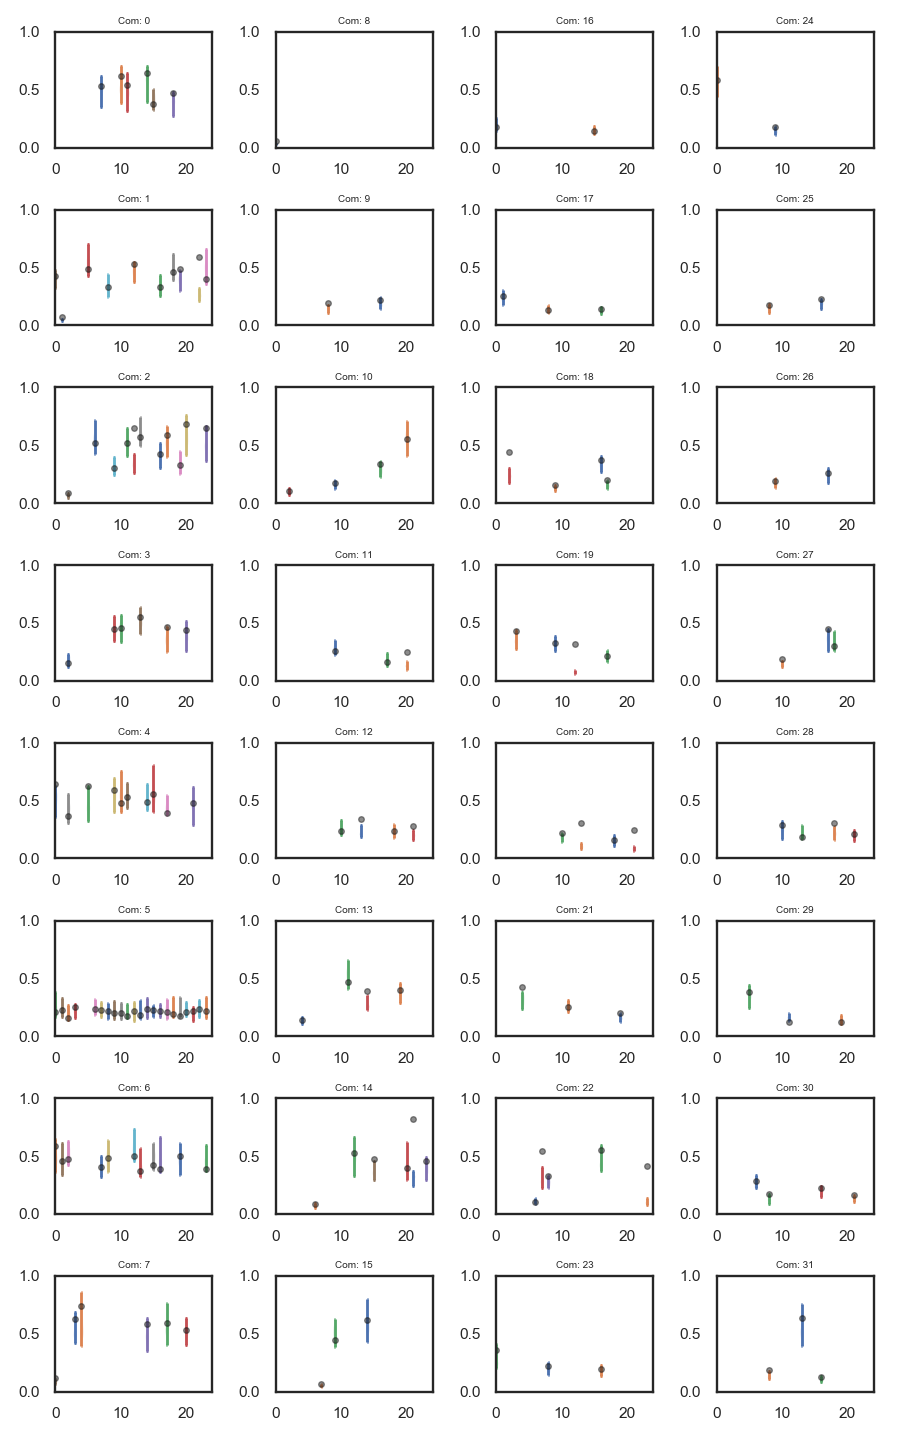

Model n_o: # commands: 157


<IPython.core.display.Javascript object>


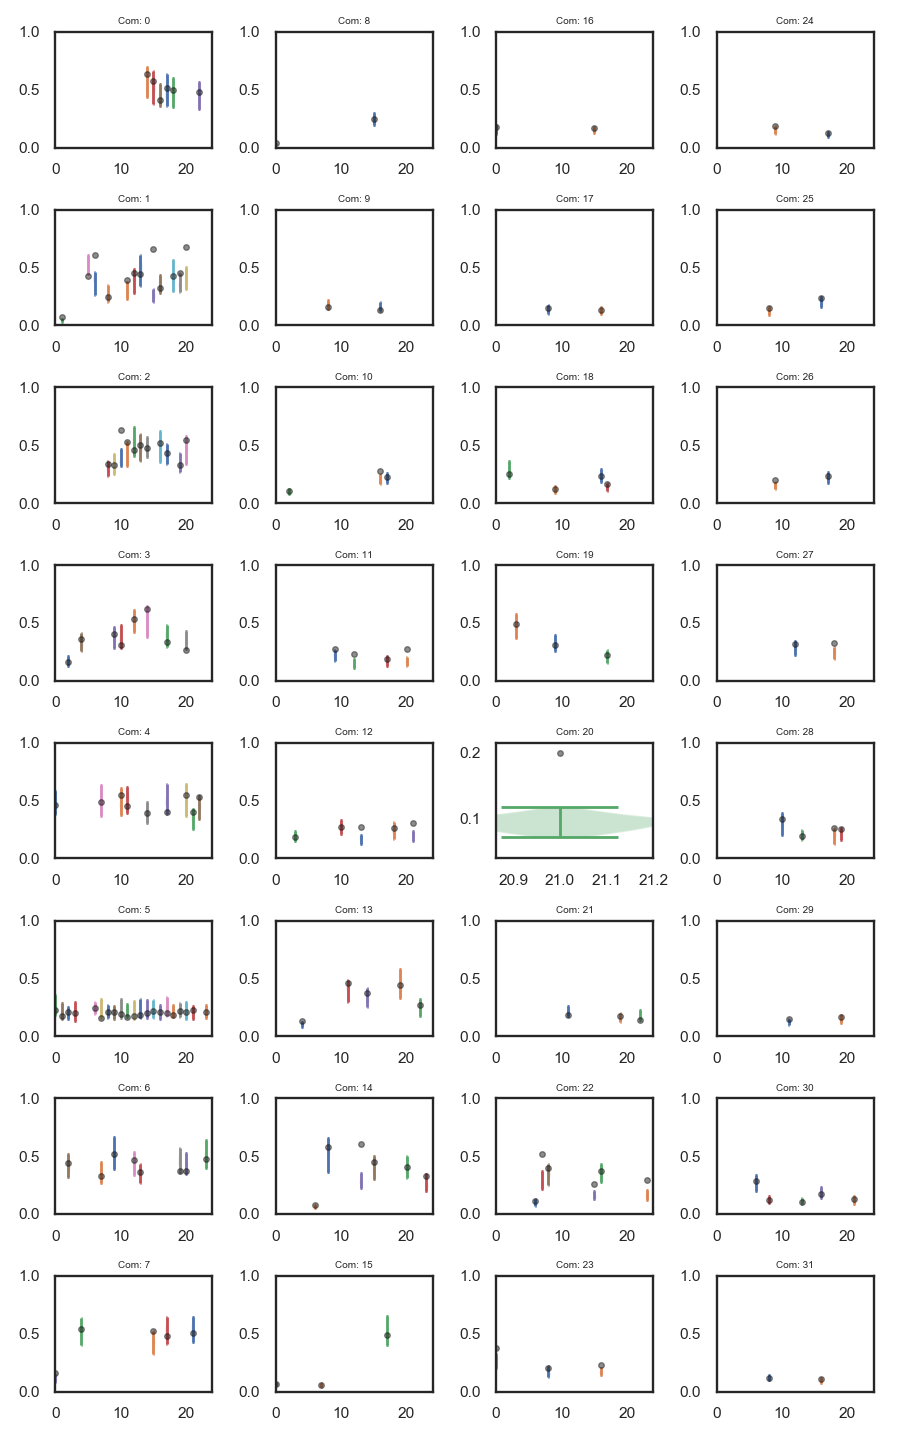

In [27]:
for pv in [.05]:#, .25, .5]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        ### get out data
        for i_m, model in enumerate(['n_do', 'n_o']): 
            act, com, cond, pot, _, _ = sim_utils.return_null_lqr_data(model = model)
            cc_dist, shuff_cc_dist = sim_utils.get_cond_com_pls_matched_inds(com, cond, act, pot, nshuff=50,
                                                                    pv=pv, pool_factor=pool_factor, min_commands=10)
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            ax = sim_utils.plot(cc_dist, shuff_cc_dist, '')


In [64]:
np.square?

In [65]:
plt.scatter?

[autoreload of online_analysis.sim_utils failed: Traceback (most recent call last):
  File "/Users/preeyakhanna/conda/envs/py27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "online_analysis/sim_utils.py", line 221
    _, px = scipy.stats.ttest_ind(val[ix0, 0], val[ix1[ix1_keep], 0])
    ^
IndentationError: unexpected indent
]
